<a href="https://colab.research.google.com/github/Beytullah-1001/Deep-Learning-Fundamentals/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-rbvgscpu
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-rbvgscpu
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


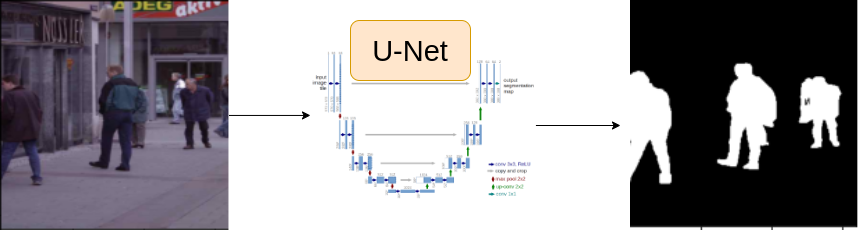

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

EPOCHS=25
LR=0.003
IMAGE_SIZE=325
BATCH_SIZE=16

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [7]:
df=pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row=df.iloc[40]
image_path=row.images 
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255


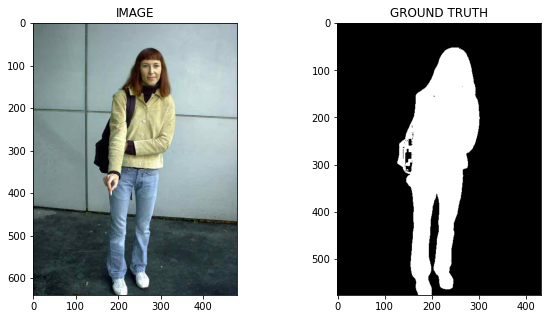

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as alb

In [12]:
def get_train_augs():
  return alb.Compose([
                      alb.Resize(IMAGE_SIZE,IMAGE_SIZE),
                      alb.HorizontalFlip(p=0.5),
                      alb.VerticalFlip(p=0.5)
  ])
def get_valid_augs():
  return alb.Compose([
                      alb.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    mask_path=row.masks
    image_path=row.images

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)#(height,weight,channel)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)#dictionary format
      image=data['image']#We access to data dictionary's image
      mask=data['mask']
    #(h#w#c)-->(c,h,w)

    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)


    return image,mask

In [15]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")


Size of Trainset : 232
Size of Validset : 58


232


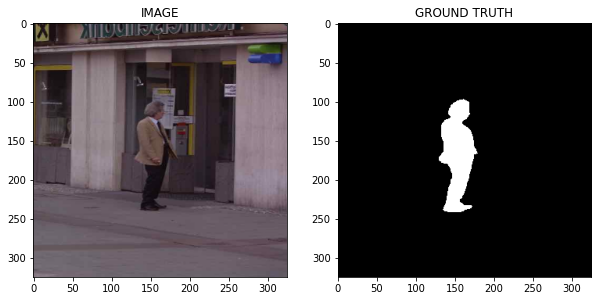

In [32]:
idx=5
print(len(trainset))
image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [31]:
train_loader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
print(len(train_loader)) 
valid_loader=DataLoader(validset,batch_size=BATCH_SIZE) 

15


In [20]:
print(f"Total Number Of Train Batches :{len(train_loader)}")
print(f"Total Number Of Validation Batches :{len(valid_loader)}")
for image,mask in train_loader:
  break


Total Number Of Train Batches :15
Total Number Of Validation Batches :4


In [21]:
print(f"One Batch image size of train batch: {image.shape}")

One Batch image size of train batch: torch.Size([16, 3, 325, 325])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
from torch.nn.modules.loss import BCELoss
class UNet(nn.Module):
  def __init__(self):
    super(UNet,self).__init__()
    self.architecture=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self,images,masks=None):
    logits=self.architecture(images)

    if masks!=None:
      diceLoss=DiceLoss(mode='binary')(logits,masks)
      bceLoss=nn.BCEWithLogitsLoss(logits,masks)
      return logits,diceLoss+bceLoss

    return logits


In [24]:
model=UNet()
model.to(DEVICE)

UNet(
  (architecture): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps=1e-

# Task 7 : Create Train and Validation Function 

In [41]:
print(len(train_loader))
def training_function(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,masks in tqdm(data_loader):
    print(images.shape)
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model.forward(images,masks)
    loss.backward()


    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(data_loader)


15


In [42]:
def eval_function(data_loader,model):
  model.eval()
  total_loss=0.0

  with torch.no_grad():

    for images,masks in tqdm(data_loader):
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)

      
      logits,loss=model(images,masks)
      



      total_loss+=loss.item()

    return total_loss/len(data_loader)


# Task 8 : Train Model

In [43]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss=np.Inf

for i in range(EPOCHS):
  train_loss=training_function(train_loader,model,optimizer)
  valid_loss=eval_function(valid_loader,model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("Saved Best Model")
    best_valid_loss=valid_loss
  print(f"Epoch {i+1}  Training Loss:{train_loss}  Validation Loss:{valid_loss}")


  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([16, 3, 325, 325])


# Task 9 : Inference

In [ ]:
idx=2
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask=validset[idx]

logits_mask=model(image.to(DEVICE).unsqueeze(0))#(C,H,W)-->(1,C,H,W)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

In [ ]:
helper.show(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya